In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBRFRegressor
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from jcopml.tuning import random_search_params as rsp
from jcopml.utils import save_model, load_model

In [4]:
df = pd.read_csv("life_expectancy.csv")
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,HepB,measles,...,Polio,total_expenditure,DPT,HIV_AIDS,GDP,population,thinness_10_19,thinness_5_9,HDI,school_year
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


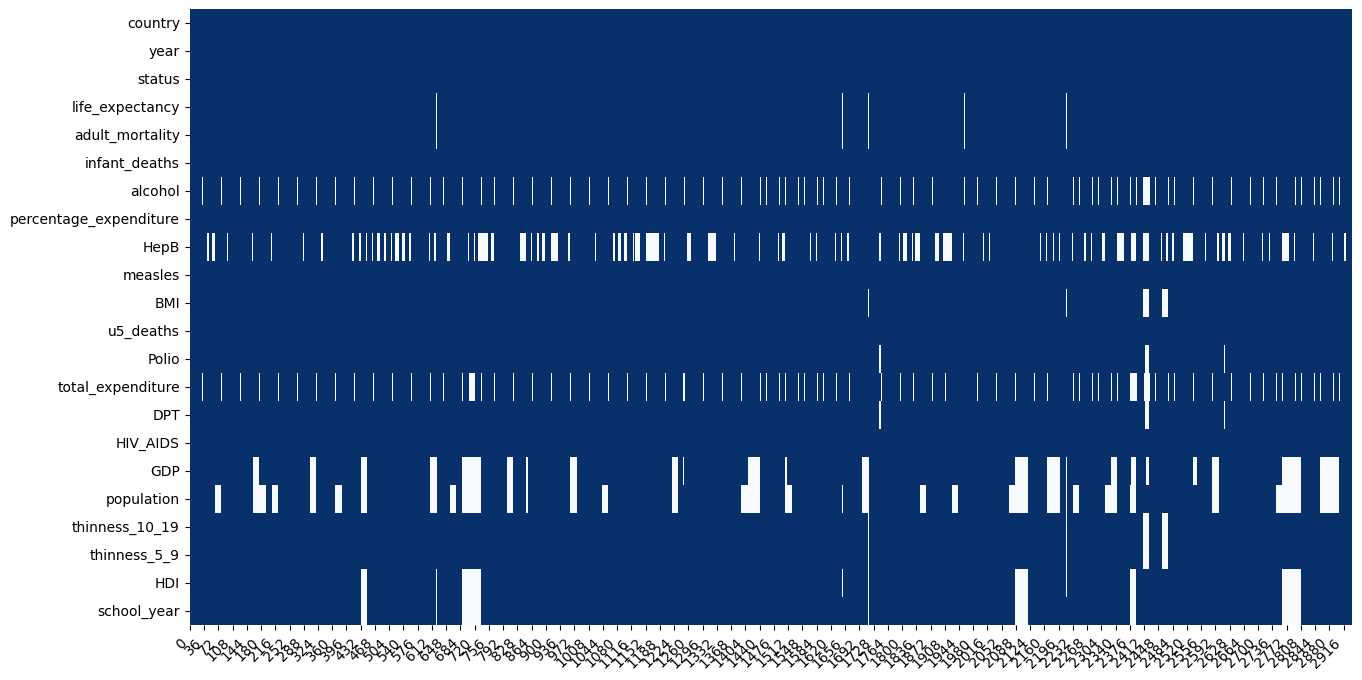

In [ ]:
plot_missing_value(df)

In [5]:
df = df[~df.life_expectancy.isna()]

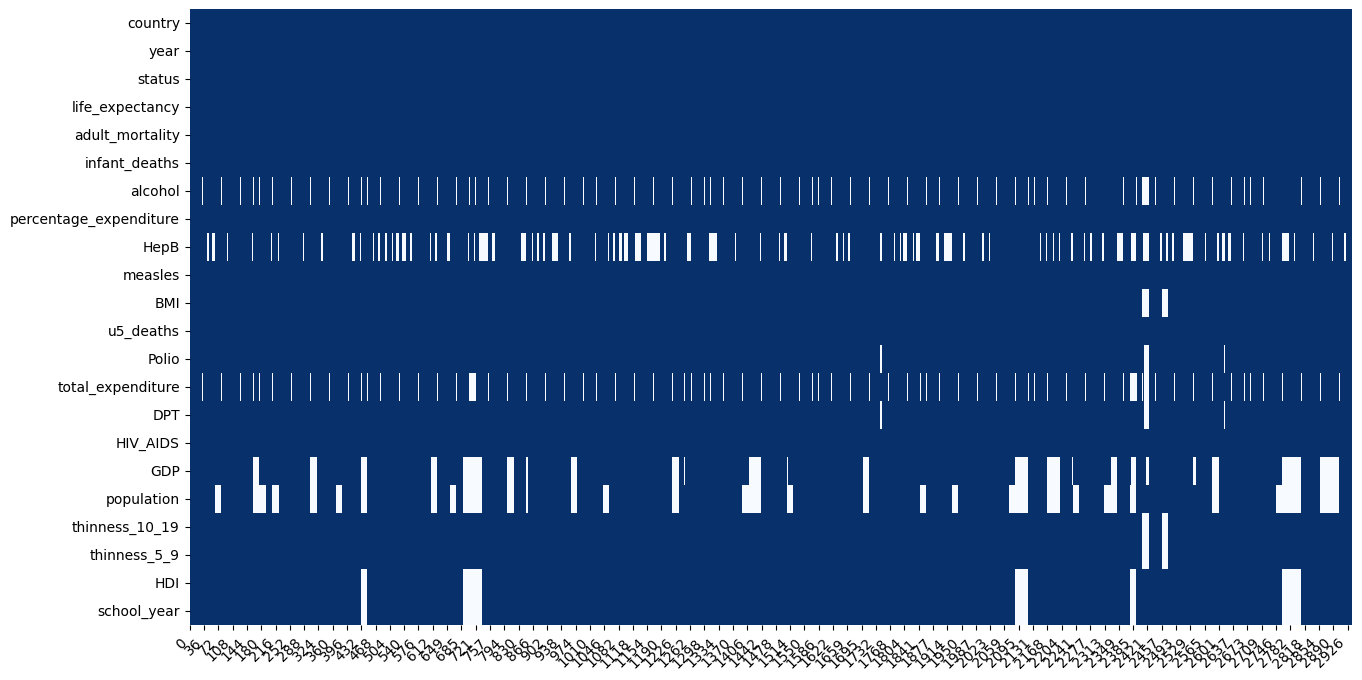

In [ ]:
plot_missing_value(df)

Dataset Splitting

In [6]:
X = df.drop(columns="life_expectancy")
y = df.life_expectancy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2342, 21), (586, 21), (2342,), (586,))

Training


In [ ]:
X_train.columns

Index(['country', 'year', 'status', 'adult_mortality', 'infant_deaths',
       'alcohol', 'percentage_expenditure', 'HepB', 'measles', 'BMI',
       'u5_deaths', 'Polio', 'total_expenditure', 'DPT', 'HIV_AIDS', 'GDP',
       'population', 'thinness_10_19', 'thinness_5_9', 'HDI', 'school_year'],
      dtype='object')

In [7]:
prepocessor = ColumnTransformer([
    ("numeric", num_pipe(), ["year", "adult_mortality", "infant_deaths", "alcohol", "percentage_expenditure", "HepB", "measles", "BMI",
                             "u5_deaths", "Polio", "total_expenditure", "DPT", "HIV_AIDS", "GDP", "population", "thinness_10_19", "thinness_5_9",
                             "HDI", "school_year"]),
    ("categoric", cat_pipe(encoder="onehot"), ["country", "status"])
])

pipeline = Pipeline([
    ("prep", prepocessor),
    ("algo", XGBRFRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params , cv=3, n_iter=50, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': np.float64(0.3853033432135068), 'algo__gamma': 3, 'algo__learning_rate': np.float64(0.9545099651237969), 'algo__max_depth': 7, 'algo__n_estimators': 139, 'algo__reg_alpha': np.float64(0.5155335702892807), 'algo__reg_lambda': np.float64(0.008965927135379428), 'algo__subsample': np.float64(0.7792288544460153)}
0.9526980562916592 0.9184016542601302 0.9348665614552347


Feature Importance

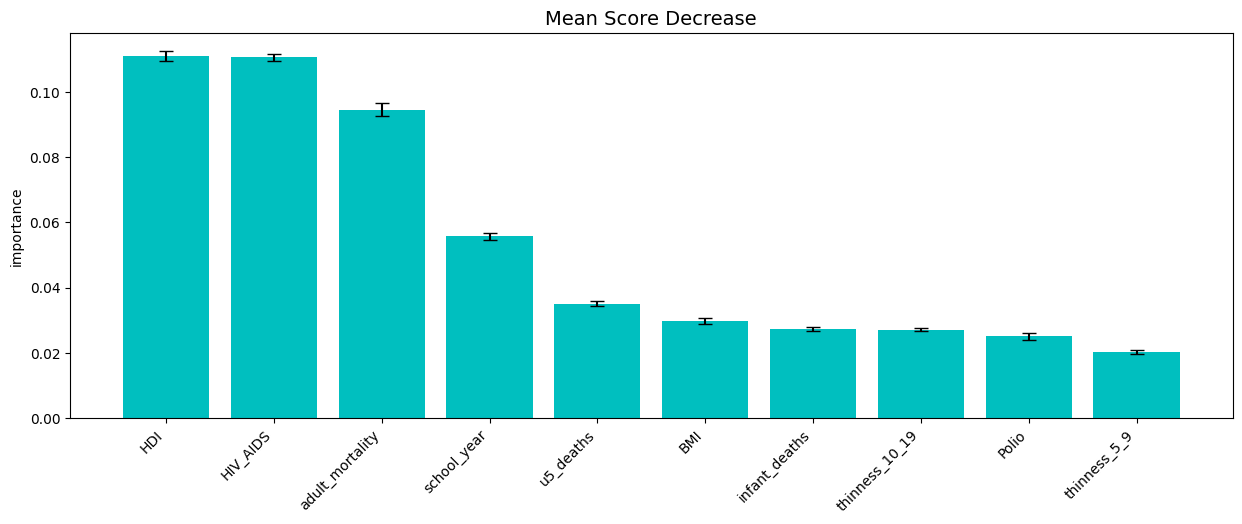

In [ ]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

In [ ]:
list(df_imp.feature)

['HDI',
 'HIV_AIDS',
 'adult_mortality',
 'school_year',
 'u5_deaths',
 'BMI',
 'infant_deaths',
 'thinness_10_19',
 'Polio',
 'thinness_5_9']

In [ ]:
list(df_imp.feature)[:5]

['HDI', 'adult_mortality', 'HIV_AIDS', 'country', 'year']

In [ ]:
prepocessor = ColumnTransformer([
    ("numeric", num_pipe(), ['HDI', 'HIV_AIDS', 'adult_mortality'])
])

pipeline = Pipeline([
    ("prep", prepocessor),
    ("algo", XGBRFRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params , cv=3, n_iter=50, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': np.float64(0.22633930841963618), 'algo__gamma': 6, 'algo__learning_rate': np.float64(0.9015604499387149), 'algo__max_depth': 4, 'algo__n_estimators': 119, 'algo__reg_alpha': np.float64(0.011400597263918191), 'algo__reg_lambda': np.float64(0.14203931350396345), 'algo__subsample': np.float64(0.5812171086454937)}
0.8094142879374605 0.8019098047231387 0.8078848183860019


Polynomial Feature

In [ ]:
# prepocessor = ColumnTransformer([
#     ("numeric", num_pipe(poly=2), ['HDI', 'HIV_AIDS', 'adult_mortality', 'school_year', 'BMI'])
# ])

# pipeline = Pipeline([
#     ("prep", prepocessor),
#     ("algo", XGBRFRegressor(n_jobs=-1, random_state=42))
# ])

# model = RandomizedSearchCV(pipeline, rsp.xgb_poly_params , cv=3, n_iter=50, n_jobs=-1, verbose=1)
# model.fit(X_train, y_train)

# print(model.best_params_)
# print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

# New Technique -> BayesianSearchCV


In [8]:
from skopt import BayesSearchCV
from jcopml.tuning import bayes_search_params as bsp

In [9]:
prepocessor = ColumnTransformer([
    ("numeric", num_pipe(), ["year", "adult_mortality", "infant_deaths", "alcohol", "percentage_expenditure", "HepB", "measles", "BMI",
                             "u5_deaths", "Polio", "total_expenditure", "DPT", "HIV_AIDS", "GDP", "population", "thinness_10_19", "thinness_5_9",
                             "HDI", "school_year"]),
    ("categoric", cat_pipe(encoder="onehot"), ["country", "status"])
])

pipeline = Pipeline([
    ("prep", prepocessor),
    ("algo", XGBRFRegressor(n_jobs=-1, random_state=42))
])

model = BayesSearchCV(pipeline, bsp.xgb_params , cv=3, n_iter=50, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

Save Model

In [ ]:
save_model(model, "xgboost_tingkat_harapan_hidup.pkl")

Load Model

In [ ]:
model_baru = load_model("xgboost_tingkat_harapan_hidup.pkl")